In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

In [2]:
%load_ext autoreload
%autoreload 2

# Steps to convert 1st set of ABF files
- read in metadata
- identify files to be converted (from mouse2019, using protocols testing intrinsic properties, ABFv2)
- merge in extracted metadata
- convert using modified ABF2Converter
- validate NWB outputs using dandi-cli
- explore errors

## Read in metadata provided by Homeira
- Focus on files testing intrinsic properties
- we find 73 ABF files that suit these criteria
- later we will read in files and determine whether they are ABFv1 or ABFv2

In [3]:
mouse_meta = pd.read_csv('./data/raw/Metadata/Mouse19_Metadatav2.csv')
mouse_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
mouse_meta.shape

(125, 13)

In [5]:
mouse_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,19o22017,Mouse,Oct 22_2019,C2,L5,Firing,After ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-66.0
1,19o22001,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-64.0
2,19o22031,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0
3,19o22037,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-67.0
4,19o22018,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0


In [6]:
mouse_meta['Stim Type'].value_counts()

Firing         58
White noise    52
Firing rate     5
Gap free        5
ZAP             3
GAP free        1
n.a             1
Name: Stim Type, dtype: int64

In [7]:
intrinsic_meta = mouse_meta[(mouse_meta['Stim Type'] == 'Firing') | (mouse_meta['Stim Type'] == 'Firing rate')]

In [8]:
intrinsic_meta['Stim Type'].value_counts()

Firing         58
Firing rate     5
Name: Stim Type, dtype: int64

## Identify files to be converted
- ABF files from mouse2019
- need metadata to determine which files are testing intrinsic properties
- extract ABF version info, time of creation and comments from the ABF file

In [9]:
mouse2019_abf_dir = Path("./data/raw/recordings/Mouse data/Mouse data_2019/")
mouse2019_file_info = utils.summary_df(mouse2019_abf_dir)

In [10]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

def check_protocolpath_for_experimenter(abf_path):
    abf = pyabf.ABF(abf_path)
    if 'Homeira' in abf.protocolPath:
        return 'Homeira'
    elif 'Lihua' in abf.protocolPath:
        return 'Lihua'
    else:
        #print(abf.protocolPath)
        return None

mouse2019_file_info['timestamp'] = mouse2019_file_info.path.apply(parse_timestamp)
mouse2019_file_info['abf_version'] = mouse2019_file_info.path.apply(extract_abf_version)
mouse2019_file_info['abf_comments'] = mouse2019_file_info.path.apply(extract_abf_comments)
mouse2019_file_info['experimenter'] = mouse2019_file_info.path.apply(check_protocolpath_for_experimenter)

# add this column to merge with provided metadata
mouse2019_file_info['file_id'] = mouse2019_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 2.94 s, sys: 1.17 s, total: 4.11 s
Wall time: 4.34 s


In [11]:
mouse2019_file_info.abf_version.value_counts()

2.6.0.0    142
1.8.4.0      3
Name: abf_version, dtype: int64

In [12]:
mouse2019_file_info.head()

,file_name,path,timestamp,abf_version,abf_comments,experimenter,file_id
0,19o09012.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 13:09:53.859,2.6.0.0,"[C3, L5, APV, CNQX, 4AP, PTX]",Homeira,19o09012
1,19o09010.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 13:08:47.640,2.6.0.0,"[C3, L5, APV, CNQX, 4AP, PTX, Command signal h...",Homeira,19o09010
2,19o09011.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 13:09:10.109,2.6.0.0,"[C3, L5, APV, CNQX, 4AP, PTX]",Homeira,19o09011
3,19o09049.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 15:16:04.750,2.6.0.0,"[C7, L5, APV, CNQX, 4AP, PTX,]",Homeira,19o09049
4,19o09048.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 15:15:56.718,2.6.0.0,"[C7, L5, APV, CNQX, 4AP, PTX,]",Homeira,19o09048


In [13]:
mouse2019_file_info.shape

(145, 7)

In [14]:
merged_meta = intrinsic_meta.merge(mouse2019_file_info, left_on='Cell Name', right_on='file_id' , how='left').drop('Cell Name', axis=1)

In [15]:
merged_meta.shape

(63, 19)

In [16]:
merged_meta.dropna(subset=['path'], inplace=True)

In [17]:
merged_meta.shape

(50, 19)

## Extract additional required stimulus metadata

In [18]:
merged_meta.iloc[0]

Data Type                                                       Mouse
Exp. Date                                                 Oct 22_2019
Cell #                                                             C2
Cell Layer                                                         L5
Stim Type                                                      Firing
ZD status                                                    After ZD
stimulus_type                                             shortsquare
Gain                                                              1.0
Offset                                                            0.0
Response Channel                                          Vm_Sec (mV)
Command Channel                                             IN 11(pA)
RMP                                                             -66.0
file_name                                                19o22017.abf
path                data/raw/recordings/Mouse data/Mouse data_2019...
timestamp           

In [19]:
# sweep through all listed abf files and extract all relevant metadata required to parse raw data
results_list = []
for i, row in merged_meta.iterrows():
    
    resp_chan = 0
    stim_chan = 0
    stim_info_dict = {}
    
    abf = pyabf.ABF(row.path)
    num_sweeps = abf.sweepCount
    abf_tag = abf.tagComments
    if abf_tag:
        abf_tag = abf_tag[0]
    else:
        abf_tag = None
    print(row.path)
    print(abf_tag)
    
    if len(abf.channelList) == 3:
        #print(abf_file)
        stim_chan = 2
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 1
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = 10
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 
                          'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(stim_dict)
        
    elif len(abf.channelList) == 4:

        stim_chan = 3
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 2
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = .2
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
    else:
        # figure out response channel
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        resp_sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)

        stim_name = 'sweepC'
        
        cell_meta_df = None
        try:
            stim_dict = utils.get_stim_dict2(row, cell_meta_df, stim_name)
        except AttributeError as e:
            print(e)
        
        # if in the odd case the number of sweeps doesn't match between resp vs stim file, then make them match
    print(f'num_sweeps: {num_sweeps}')
    print(f'stim_dict: {stim_dict}')
    if num_sweeps != stim_dict['num_sweeps']:
        #print(abf_file)
        stim_dict['num_sweeps'] = num_sweeps
        stim_dict['stim_amp_vec'] = stim_dict['stim_amp_vec'][0:num_sweeps]
        
    ret_dict = {'cell_id' : row.file_id, 'resp_chan' : resp_chan, 
                'resp_gain' : best_gain, 'rmp_error' : rmp_abs_error, 'abf_tag' : abf_tag,
                'rmp_val' : row.RMP, 'resp_offset' : row.Offset,
                'abf_version' : abf.abfVersionString, 'resp_sampling_rate' : resp_sampling_rate, 'stim_name' : stim_name, 
               'file_time' : abf.abfDateTime}
    #ret_dict = dict(ret_dict.items() + stim_info_dict.items())
    ret_dict.update(stim_dict)
    #print(ret_dict)

    results_list.append(ret_dict)
    print('--'*50)

data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/After ZD/19o22017.abf
C2, L5, APV,CNQX,PTX,
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 12
stim_dict: {'stim_chan': 0, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/After ZD/19o22017.abf', 'valid_stim': False, 'stim_amp_vec': array([0., 0., 0., ..., 0., 0., 0.]), 'stim_duration': 2.6322, 'stim_start_time': 0.0, 'stim_end_time': 2.63215, 'num_sweeps': 12, 'stim_sampling_rate': 20000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/Before ZD/19o22001.abf
C2, L5, APV,CNQX,PTX
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/Before ZD/19o22001.abf', 'valid_stim': True, 'stim_amp_vec': array([-300., -250., -200., 

num_sweeps: 11
stim_dict: {'stim_chan': 0, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08011.abf', 'valid_stim': False, 'stim_amp_vec': array([0., 0., 0., ..., 0., 0., 0.]), 'stim_duration': 2.6322, 'stim_start_time': 0.0, 'stim_end_time': 2.63215, 'num_sweeps': 11, 'stim_sampling_rate': 20000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08012.abf
C2, L5, SS, KA mice,RMP -67.8 mv
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08012.abf', 'valid_stim': True, 'stim_amp_vec': array([-300., -250., -200., ...,  300.,  350.,  400.]), 'stim_duration': 0.6, 'stim_start_time': 0.0921, 'stim_end_time': 0.69205, 'num_sweeps': 15, 'stim_sampling_rate': 20000}
---

sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 14
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09057.abf', 'valid_stim': True, 'stim_amp_vec': array([-300., -250., -200., ...,  250.,  300.,  350.]), 'stim_duration': 0.6, 'stim_start_time': 0.0921, 'stim_end_time': 0.69205, 'num_sweeps': 14, 'stim_sampling_rate': 20000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09058.abf
C8, L5, APV, CNQX, 4AP, PTX,
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 18
stim_dict: {'stim_chan': 0, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09058.abf', 'valid_stim': False, 'stim_amp_vec': array([0., 0., 0., ..., 0., 0., 0.]), 'stim_duration': 2.6322, 'stim_start_time': 0.0, 'stim_end_time': 2.63215, 'num_sweeps': 18, '

num_sweeps: 27
stim_dict: {'stim_chan': 0, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C7_L5/Firing rate/19o09050.abf', 'valid_stim': False, 'stim_amp_vec': array([0., 0., 0., ..., 0., 0., 0.]), 'stim_duration': 2.6322, 'stim_start_time': 0.0, 'stim_end_time': 2.63215, 'num_sweeps': 27, 'stim_sampling_rate': 20000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23039.abf
C6, L5, APV,CNQX,PTX,,
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23039.abf', 'valid_stim': True, 'stim_amp_vec': array([-300., -250., -200., ...,  300.,  350.,  400.]), 'stim_duration': 0.6, 'stim_start_time': 0.0921, 'stim_end_time': 0.69205, 'num_sweeps': 15, 'stim_sampling_rate': 20000}
-----

In [20]:
extracted_meta = pd.DataFrame(results_list)

In [22]:
all_meta = merged_meta.merge(extracted_meta.drop('abf_version', axis=1), left_on='file_id', right_on='cell_id')

In [23]:
meta_path = Path('./data/processed/meta')
meta_path.mkdir(exist_ok=True)
all_meta.to_csv(meta_path / 'm2019_meta.csv')

In [24]:
all_meta.iloc[0]

Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                      After ZD
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                               -66.0
file_name                                                  19o22017.abf
path                  data/raw/recordings/Mouse data/Mouse data_

## Convert

In [25]:
output_dir = Path("data/processed/recordings/mouse2019")
output_dir.mkdir(exist_ok=True)

In [26]:
from x_to_nwb import ABF2Converter
from x_to_nwb import ABF1Converter

In [27]:
%%time
errors = []

for i, file_info in meta.iterrows():
    print(file_info)
    try:
        abf = pyabf.ABF(file_info.path) # abf file to be converted
        file_stem = file_info.cell_id # file stem with no file type
        
        # figure out if stimulus is on dac or adc channels
        if file_info.stim_name == 'sweepC': 
            stim_chan = abf.dacNames[file_info.stim_chan] 
        else: #if stim_name is sweepY
            stim_chan = abf.adcNames[file_info.stim_chan] 
        
        resp_chan = abf.adcNames[file_info.resp_chan] # response seems always to be in adc channels
        
        # this should be populated with metadata from homeira!
        meta = {
            'Subject': {
                'age': None,
                'description': f'{file_info.abf_tag}',
                'species': 'Homo sapiens',
                'subject_id': f'Donor_'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        
        if file_info.abf_version == '2.6.0.0': # if abf v2 file
            # i didn't use gain here because none of my abf v2 files needed a gain - feel free to add one though
            nwb = ABF2Converter.ABF2Converter(file_info.path, 
                                              str(output_path), 
                                              includeChannelList=[resp_chan], 
                                              stimulus_name=stim_chan, 
                                              metadata=meta)
        
        else: # if abf 1 file
            nwb = ABF1Converter.ABF1Converter(inputPath = file_info.path, 
                                              outputFilePath = str(output_path), 
                                              acquisitionChannelName = resp_chan, 
                                              stimulusChannelName = stim_chan,
                                              metadata=meta, 
                                              responseGain = file_info.resp_gain, # gain on response channel
                                              stimulusGain = file_info.stim_gain, # gain on stimulus channel
                                              responseOffset = file_info.resp_offset) # voltage offset on resp channel
            nwb.convert()
        print(nwb)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        print('--'*50)
        
    except (ValueError, IndexError, TypeError, KeyError, UnicodeDecodeError,AttributeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/After ZD/19o22017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                      After ZD
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                               -66.0
file_name                                                  19o22017.abf
path                  data/raw/recordings/Mouse data/Mouse data_

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset I-V curve ,-400 pA, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:550: UserWarning: Could not find settings for amplifier unknown of channel Vm_sec.
  warnings.warn(f"Could not find settings for amplifier {amplifier} of channel {adcName}.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/Before ZD/19o22001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22017.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/After ZD/19o22031.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22001.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                      After ZD
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/After ZD/19o22037.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22031.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                      After ZD
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset Ramp 1S-190-330-20, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22018.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22037.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22019.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22018.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22020.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22019.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C4_L5/Firing/After ZD/19o23033.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22020.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C4
Cell Layer                                                       L5-Int
Stim Type                                                        Firing
ZD status                                                      After ZD
stimulus_type                                                       NaN
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C4_L5/Firing/Before ZD/19o23019.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23033.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C8_L5/Firing/Before ZD/19o23056.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23019.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C8
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C1_L5/Firing/After CA/2019_10_24_0035.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23056.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 24_ 2019_CA
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                      After CA
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C3_L5/Firing/After CA/2019_10_24_0063.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_10_24_0035.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 24_ 2019_CA
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                      After CA
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                       

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C3_L5/Firing/Before CA/2019_10_24_0050.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_10_24_0063.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 24_ 2019_CA
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before CA
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                       

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C1_L5/Firing/19o08001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_10_24_0050.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                       

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C1_L5/Firing/19o08002.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08001.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C1_L5/Firing/19o08003.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08002.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08003.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08011.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08010.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08011.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C3_L5/Firing/19o08017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08012.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C3_L5/Firing/19o08018.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08017.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C3_L5/Firing/19o08020.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08018.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C4_L5/Firing/19o08025.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08020.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C4_L5/Firing/19o08026.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08025.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C4_L5/Firing/19o08027.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08026.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 08_ 2019_KA
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C3_L5/Firing/19o09012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o08027.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C4_L5/Firing/19o09016.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09012.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C4_L5/Firing/19o09017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09016.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C4_L5/Firing/19o09018.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09017.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C6_L5/Firing/19o09042.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09018.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C6
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C6_L5/Firing/19o09043.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09042.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C6
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09057.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09043.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C8
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09058.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09057.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C8
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09059.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09058.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C8
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C1_L5/Firing/19o23001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09059.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C2_L5/Firing/19o23003.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23001.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C2_L5/Firing/19o23005.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23003.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C2_L5/Firing/19o23006.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23005.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C3_L5/Firing/19o23010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23006.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C3_L5/Firing/19o23012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23010.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C7_L5/Firing/19o23046.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23012.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C7
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C2_L5/Firing/2019_10_24_0037.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23046.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 24_ 2019_CA
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C2_L5/Firing/2019_10_24_0038.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_10_24_0037.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 24_ 2019_CA
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                       

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C2_L5/Firing/2019_10_24_0039.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_10_24_0038.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 24_ 2019_CA
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                       

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C4_L5/Firing/2019_10_24_0073.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_10_24_0039.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                               Oct 24_ 2019_CA
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                       

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C7_L5/Firing rate/19o09049.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_10_24_0073.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C7
Cell Layer                                                           L5
Stim Type                                                   Firing rate
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                       

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C7_L5/Firing rate/19o09050.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09049.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                              Oct 09_ 2019_4AP
Cell #                                                               C7
Cell Layer                                                           L5
Stim Type                                                   Firing rate
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23039.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o09050.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C6
Cell Layer                                                           L5
Stim Type                                                   Firing rate
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23040.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23039.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C6
Cell Layer                                                           L5
Stim Type                                                   Firing rate
ZD status                                                           n.a
stimulus_type                                               shortsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23041.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23040.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C6
Cell Layer                                                           L5
Stim Type                                                   Firing rate
ZD status                                                           n.a
stimulus_type                                                      ramp
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 10(pA)
RMP                                                              

## Plot NWB files

In [31]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

nwb_files = utils.summary_df(path=Path('./data/processed/recordings/mouse2019/'), suffix='.nwb')

loading dataset into data structure...
data/processed/recordings/mouse2019/19o08001.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08002.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08003.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08010.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08011.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08012.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08017.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08018.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08020.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08025.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08026.nwb
loading dataset into data struct

/Users/derek_howard/triplab/nwb_conversion/utils.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2, 1, sharex=True)


loading dataset into data structure...
data/processed/recordings/mouse2019/19o09058.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09059.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22001.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22017.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22018.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22019.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22020.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22031.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22037.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o23001.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o23003.nwb
loading dataset into data struct

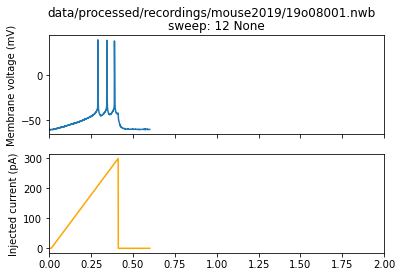

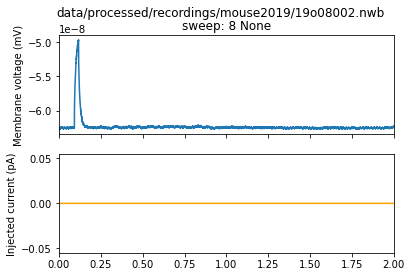

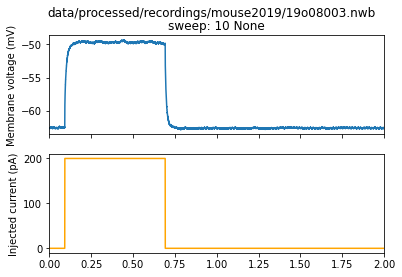

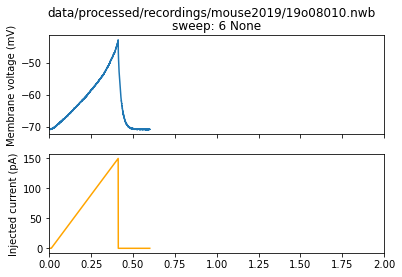

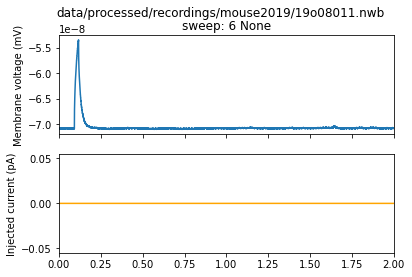

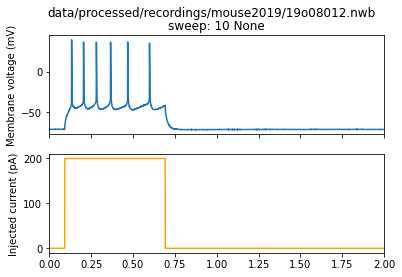

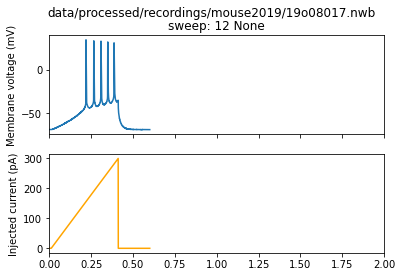

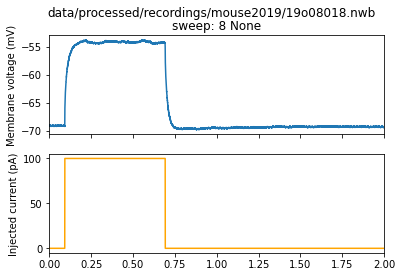

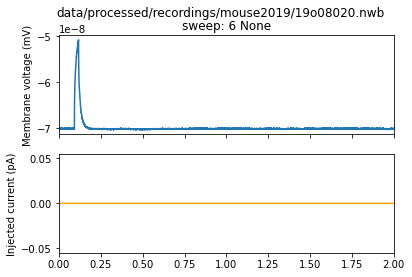

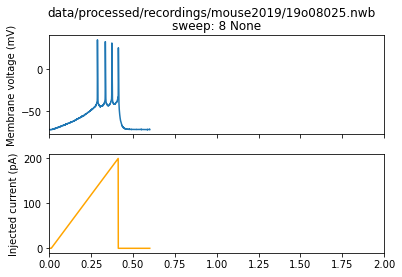

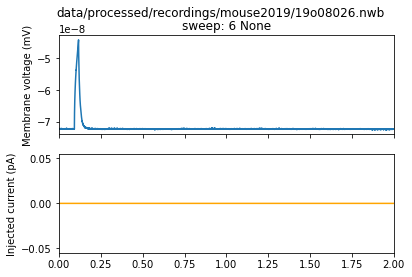

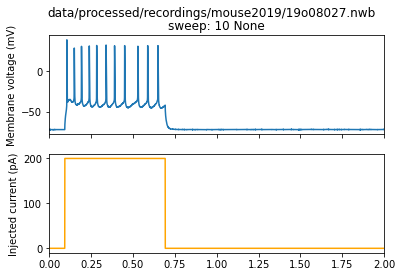

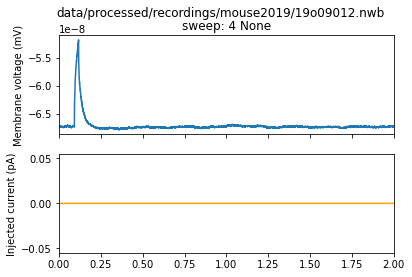

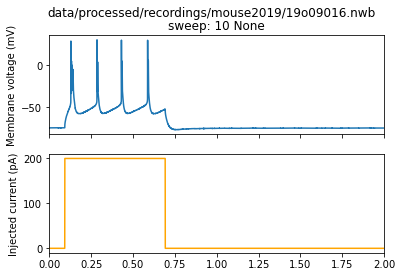

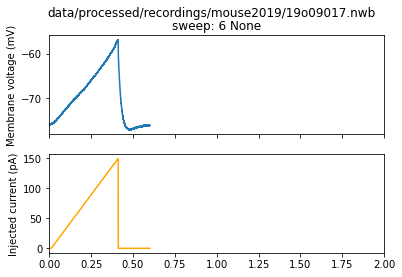

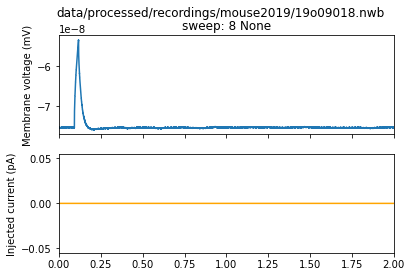

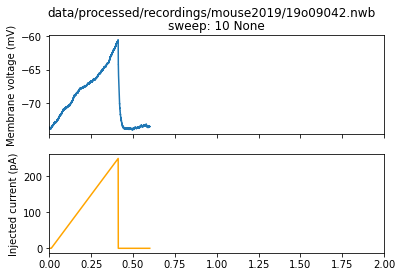

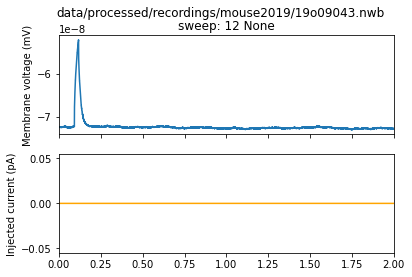

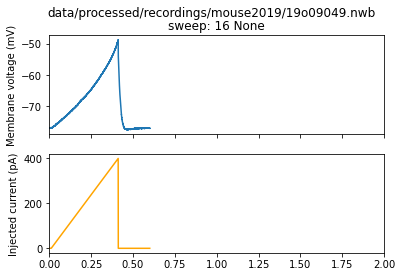

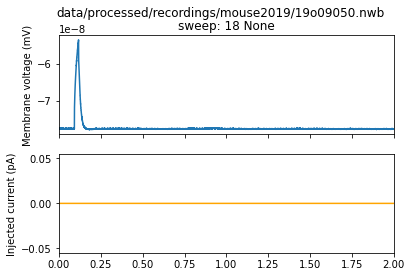

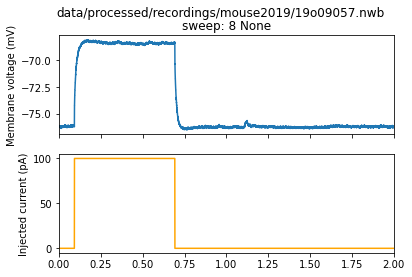

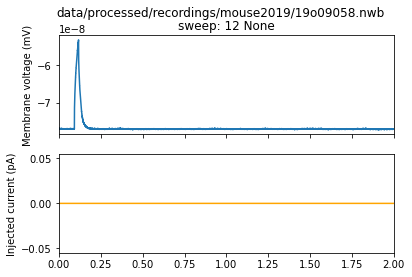

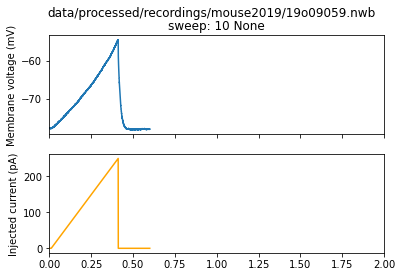

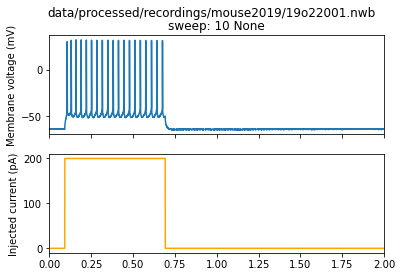

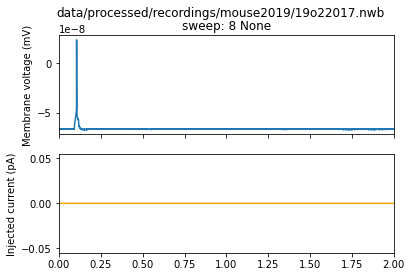

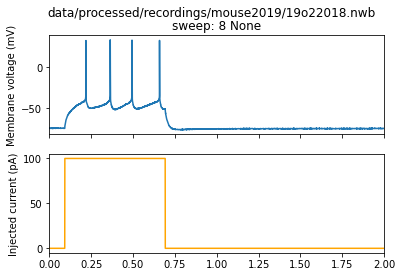

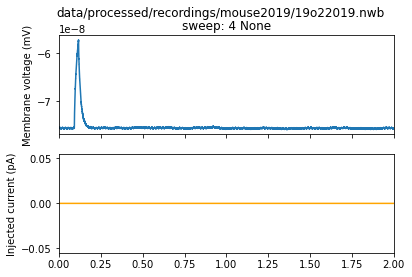

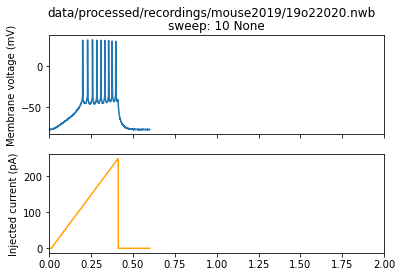

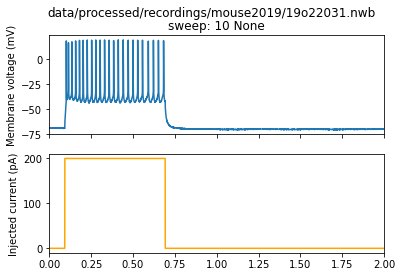

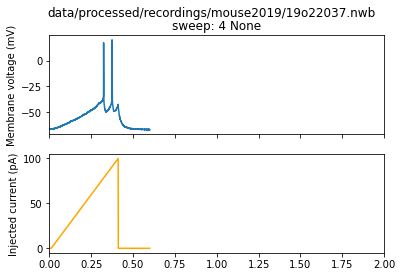

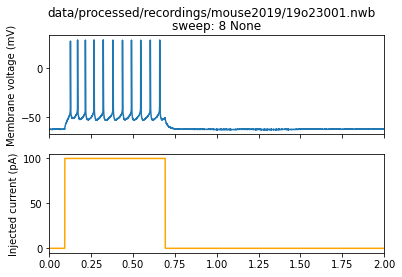

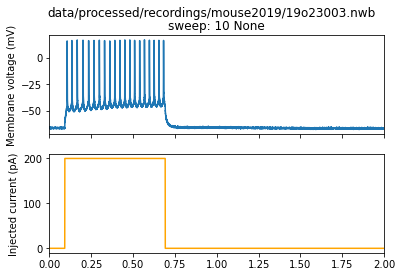

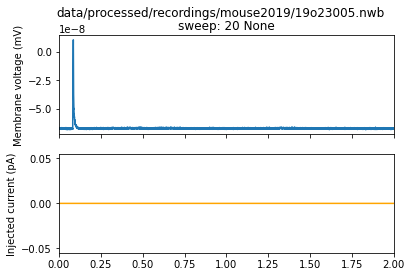

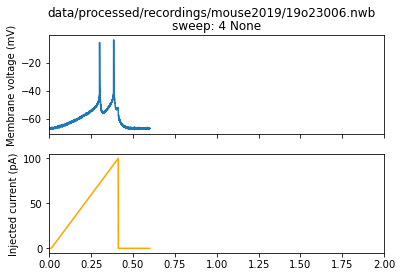

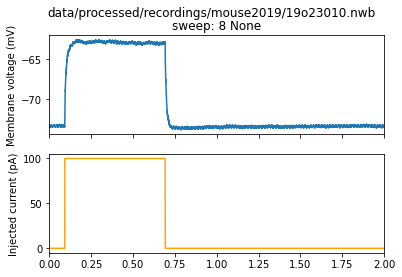

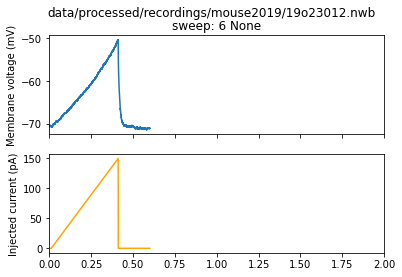

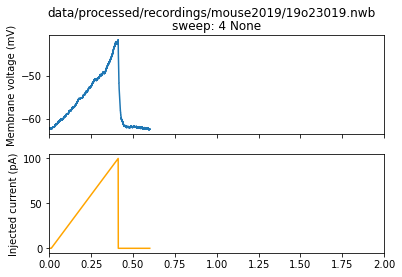

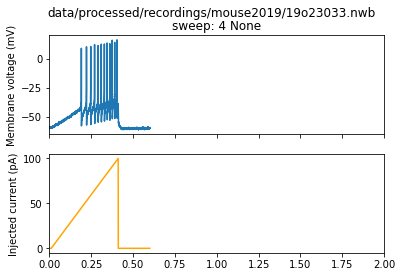

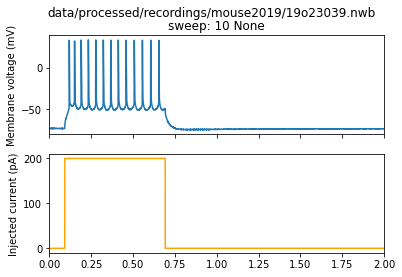

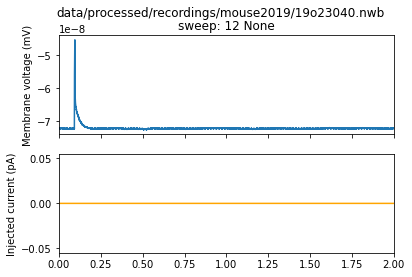

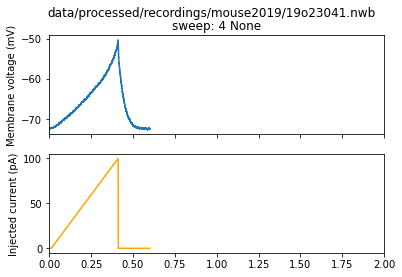

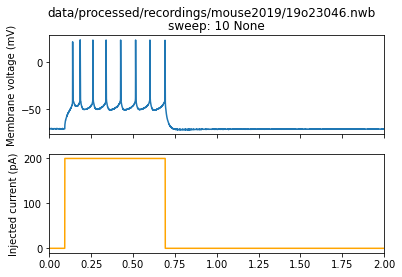

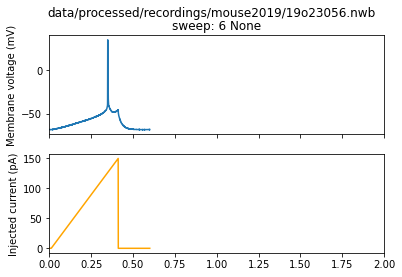

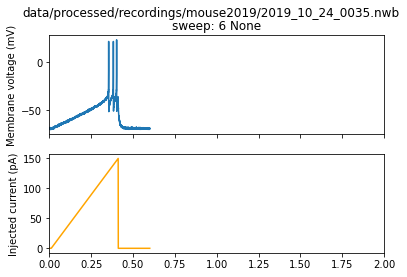

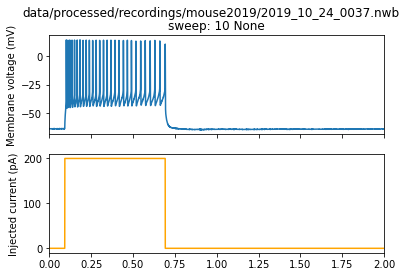

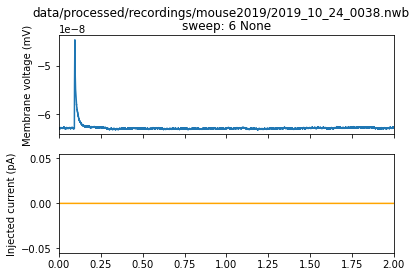

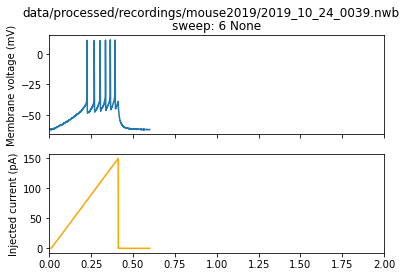

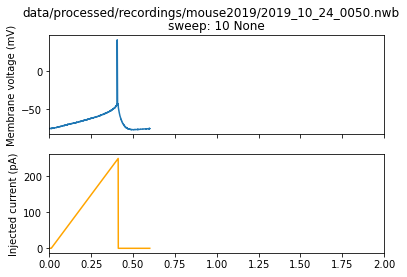

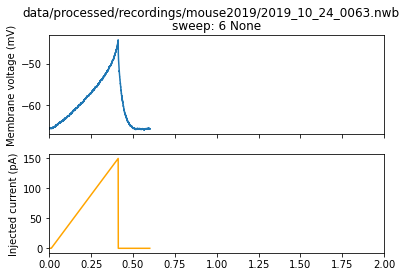

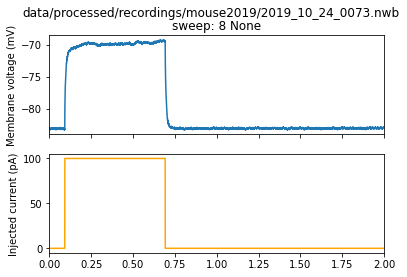

In [32]:
for i, row in nwb_files.sort_values('file_name').iterrows():
    utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)

In [28]:
!dandi validate ./data/processed/recordings/mouse2019/

2021-11-10 13:37:13,110 [    INFO] NumExpr defaulting to 8 threads.
2021-11-10 13:37:15,954 [    INFO] ./data/processed/recordings/mouse2019/19o09012.nwb: ok
2021-11-10 13:37:17,650 [    INFO] ./data/processed/recordings/mouse2019/19o23003.nwb: ok
2021-11-10 13:37:19,281 [    INFO] ./data/processed/recordings/mouse2019/19o23001.nwb: ok
2021-11-10 13:37:20,967 [    INFO] ./data/processed/recordings/mouse2019/19o23010.nwb: ok
2021-11-10 13:37:22,556 [    INFO] ./data/processed/recordings/mouse2019/2019_10_24_0035.nwb: ok
2021-11-10 13:37:24,370 [    INFO] ./data/processed/recordings/mouse2019/19o23039.nwb: ok
2021-11-10 13:37:26,680 [    INFO] ./data/processed/recordings/mouse2019/19o23005.nwb: ok
2021-11-10 13:37:28,501 [    INFO] ./data/processed/recordings/mouse2019/19o09017.nwb: ok
2021-11-10 13:37:30,226 [    INFO] ./data/processed/recordings/mouse2019/19o09016.nwb: ok
2021-11-10 13:37:32,018 [    INFO] ./data/processed/recordings/mouse2019/2019_10_24_0037.nwb: ok
2021-11-10 13:37:3